In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binom
import warnings
warnings.filterwarnings('ignore')

In [2]:
#coach and first-class(no overbooking in first-class)
#if overbook in coach and first-class available then you can put them in first class --> overbooking cost
#overbooking policy
# If first-class os sold out then coach prob of buying +3% regarding of price


# Parameters

In [3]:
ndays = 365
T = ndays

nseat_coa = 100
nseat_1st = 20
nseat_over = 5

showup_coa = 0.95
showup_1st = 0.97

bump_1st = 50
bump_out = 425

price_coa = [300,350]
price_1st = [425,500]

# 0 - LL price_1stclass price_coach
# 1 - HL
# 2 - LH
# 3 - HH
# 4 - L0
# 5 - H0
# 6 - 0L
# 7 - 0H
# 8 - 00

dema_coa = [0.65,0.3]
dema_1st = [0.08,0.04]

r_year = 0.17
r = 1/(1+r_year/365)

extra_d = 0.03


## State variables

In [4]:
s_coa_values = np.arange(nseat_coa+nseat_over+1) #number of seats sold coa
s_1st_values = np.arange(nseat_1st+1) #number of seats sold 1st

t_values = np.arange(ndays+1)


## Value function and choice variables

In [5]:
V = np.zeros((nseat_1st+1,nseat_coa+nseat_over+1,ndays+1))
U = np.zeros((nseat_1st+1,nseat_coa+nseat_over+1,ndays+1))

## terminal cost

In [6]:
for s_1st in s_1st_values:
    for s_coa in s_coa_values:
        exp_cost = 0
        for n_1st in range(s_1st+1):
            for n_coa in range(s_coa+1):
                prob_show_1st = binom.pmf(n_1st, s_1st, showup_1st)
                prob_show_coa = binom.pmf(n_coa, s_coa, showup_coa)
                n_ava_1st = nseat_1st-n_1st
                if n_coa>nseat_coa:
                    if (n_coa-nseat_coa)<=n_ava_1st:
                        cost = (n_coa-nseat_coa)*bump_1st
                    else:
                        cost = n_ava_1st*bump_1st+(n_coa-nseat_coa-n_ava_1st)*bump_out
                else:
                    cost=0

                exp_cost += cost*prob_show_1st*prob_show_coa                
        V[s_1st,s_coa,T] = -exp_cost


## Bellman

In [7]:
for t in reversed(range(ndays)):
    for s_1st in s_1st_values:
        if s_1st==nseat_1st:
            for s_coa in (s_coa_values):
                if s_coa==(nseat_coa+nseat_over):
                    V[s_1st,s_coa,t] = 0 + r*V[s_1st,s_coa,t+1]
                    U[s_1st,s_coa,t] = 8
                else:
                    v_coa_1st = [price_coa[0]*(dema_coa[0]+extra_d)+r*(V[s_1st,s_coa+1,t+1]*(dema_coa[0]+extra_d)+
                                                                       V[s_1st,s_coa,t+1]*(1-dema_coa[0]-extra_d)),
                                 
                                 price_coa[1]*(dema_coa[1]+extra_d)+r*(V[s_1st,s_coa+1,t+1]*(dema_coa[1]+extra_d)+
                                                                       V[s_1st,s_coa,t+1]*(1-dema_coa[1]-extra_d))] 
                    
                    V[s_1st,s_coa,t] = np.max(v_coa_1st)
                    U[s_1st,s_coa,t] = 6 + np.argmax(v_coa_1st)                                      
        else:
            for s_coa in (s_coa_values):
                if s_coa==(nseat_coa+nseat_over):
                    v_coa_1st = [price_1st[0]*dema_1st[0]+r*(V[s_1st+1,s_coa,t+1]*dema_1st[0]+
                                                             V[s_1st,s_coa,t+1]*(1-dema_1st[0])),
                                 price_1st[1]*dema_1st[1]+r*(V[s_1st+1,s_coa,t+1]*dema_1st[1]+
                                                             V[s_1st,s_coa,t+1]*(1-dema_1st[1]))]

                    V[s_1st,s_coa,t] = np.max(v_coa_1st)
                    U[s_1st,s_coa,t] = np.argmax(v_coa_1st)+4   
                else:  
                    
                    v_coa_1st = [(price_1st[0]+price_coa[0])*dema_1st[0]*dema_coa[0]+
                                 (price_1st[0])*dema_1st[0]*(1-dema_coa[0])+
                                 (price_coa[0])*(1-dema_1st[0])*dema_coa[0]+r*(V[s_1st+1,s_coa+1,t+1]*dema_1st[0]*dema_coa[0]+
                                                                               V[s_1st+1,s_coa  ,t+1]*dema_1st[0]*(1-dema_coa[0])+
                                                                               V[s_1st,s_coa+1,t+1]*(1-dema_1st[0])*dema_coa[0] +
                                                                               V[s_1st,s_coa,t+1]*(1-dema_1st[0])*(1-dema_coa[0])),
                                 (price_1st[1]+price_coa[0])*dema_1st[1]*dema_coa[0]+
                                 (price_1st[1])*dema_1st[1]*(1-dema_coa[0])+
                                 (price_coa[0])*(1-dema_1st[1])*dema_coa[0]+r*(V[s_1st+1,s_coa+1,t+1]*dema_1st[1]*dema_coa[0]+
                                                                               V[s_1st+1,s_coa  ,t+1]*dema_1st[1]*(1-dema_coa[0])+
                                                                               V[s_1st,s_coa+1,t+1]*(1-dema_1st[1])*dema_coa[0] +
                                                                               V[s_1st,s_coa,t+1]*(1-dema_1st[1])*(1-dema_coa[0])),
                                 (price_1st[0]+price_coa[1])*dema_1st[0]*dema_coa[1]+
                                 (price_1st[0])*dema_1st[0]*(1-dema_coa[1])+
                                 (price_coa[1])*(1-dema_1st[0])*dema_coa[1]+r*(V[s_1st+1,s_coa+1,t+1]*dema_1st[0]*dema_coa[1]+
                                                                               V[s_1st+1,s_coa  ,t+1]*dema_1st[0]*(1-dema_coa[1])+
                                                                               V[s_1st,s_coa+1,t+1]*(1-dema_1st[0])*dema_coa[1] +
                                                                               V[s_1st,s_coa,t+1]*(1-dema_1st[0])*(1-dema_coa[1])),
                                 (price_1st[1]+price_coa[1])*dema_1st[1]*dema_coa[1]+
                                 (price_1st[1])*dema_1st[1]*(1-dema_coa[1])+
                                 (price_coa[1])*(1-dema_1st[1])*dema_coa[1]+r*(V[s_1st+1,s_coa+1,t+1]*dema_1st[1]*dema_coa[1]+
                                                                               V[s_1st+1,s_coa  ,t+1]*dema_1st[1]*(1-dema_coa[1])+
                                                                               V[s_1st,s_coa+1,t+1]*(1-dema_1st[1])*dema_coa[1] +
                                                                               V[s_1st,s_coa,t+1]*(1-dema_1st[1])*(1-dema_coa[1]))
                                ]                    
                
                    V[s_1st,s_coa,t] = np.max(v_coa_1st)
                    U[s_1st,s_coa,t] = np.argmax(v_coa_1st)  



## Results

In [8]:
V_reshaped = V.reshape(V.shape[0] * V.shape[1], V.shape[2])  
V_df = pd.DataFrame(V_reshaped, index=pd.MultiIndex.from_product([s_1st_values, s_coa_values], names=['s_1st', 's_coa']), columns=t_values)
V_df.to_csv('question1_V.csv')

U_reshaped = U.reshape(U.shape[0] * U.shape[1], U.shape[2])  
U_df = pd.DataFrame(U_reshaped, index=pd.MultiIndex.from_product([s_1st_values, s_coa_values], names=['s_1st', 's_coa']), columns=t_values)
U_df.to_csv('question1_U.csv')


In [9]:
V[0,0,0]

41886.15862419569

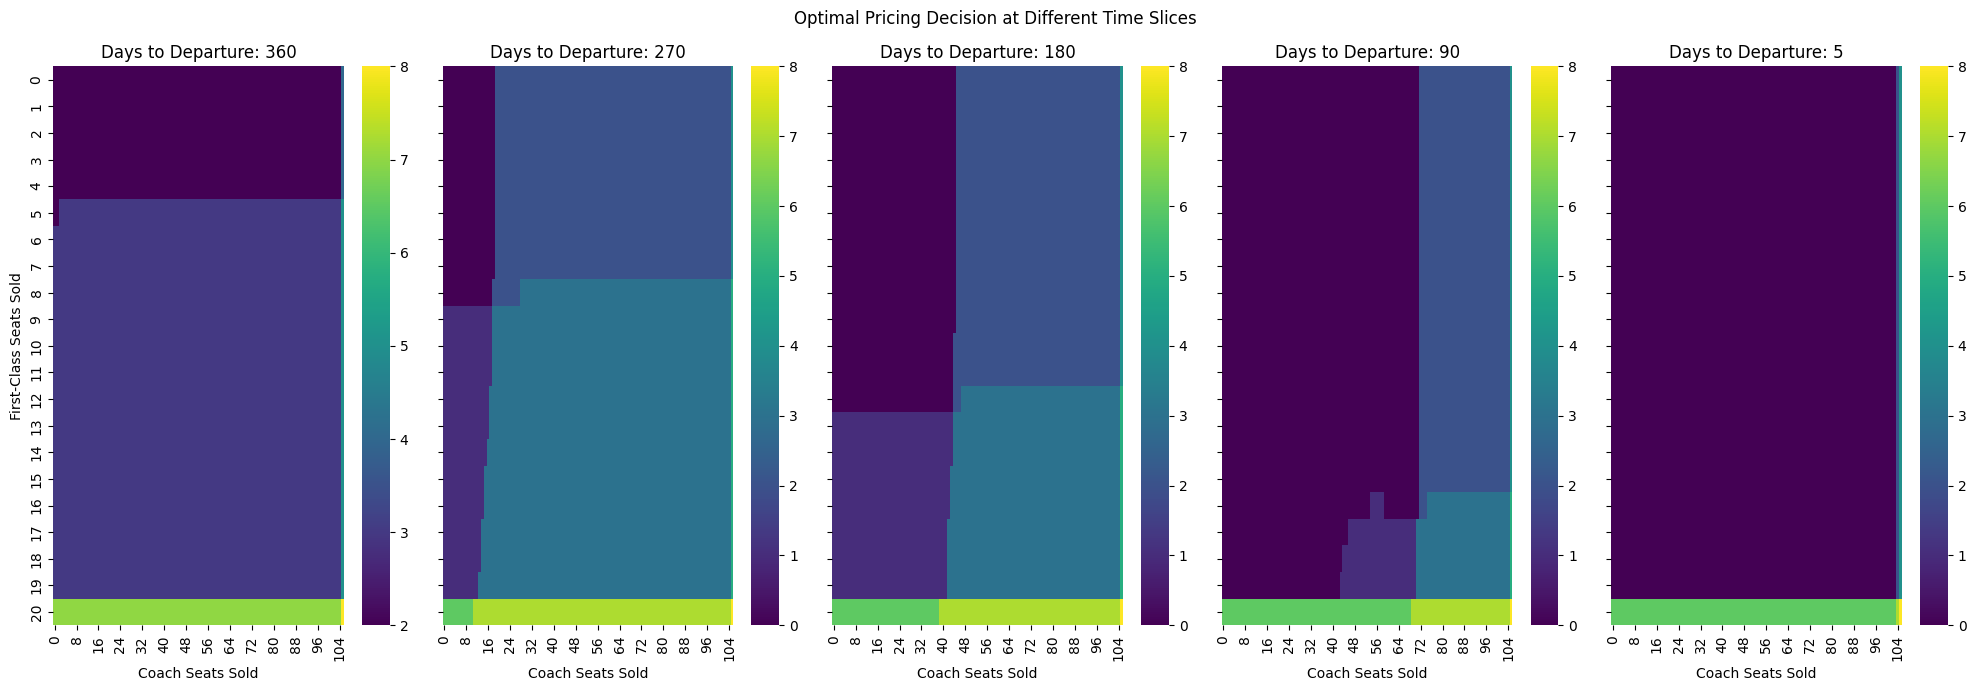

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(1, 5, figsize=(20, 7), sharey=True)

time_slices = [360, 270, 180, 90, 5]  

for i, t in enumerate(time_slices):
    sns.heatmap(U[:, :, 366 - t], ax=axes[i], cmap='viridis')
    axes[i].set_title(f'Days to Departure: {t}')
    axes[i].set_xlabel('Coach Seats Sold')
    if i == 0:  
        axes[i].set_ylabel('First-Class Seats Sold')

plt.suptitle('Optimal Pricing Decision at Different Time Slices')
plt.tight_layout()
plt.show()



# Second Part

In [11]:
ndays = 365
T = ndays

nseat_coa = 100
nseat_1st = 20
#nseat_over = 5

showup_coa = 0.95
showup_1st = 0.97

bump_1st = 50
bump_out = 425

price_coa = [300,350]
price_1st = [425,500]

# 0 - LL
# 1 - HL
# 2 - LH
# 3 - HH
# 4 - L0
# 5 - H0
# 6 - 0L
# 7 - 0H
# 8 - 00

dema_coa = [0.65,0.3]
dema_1st = [0.08,0.04]

r_year = 0.17
r = 1/(1+r_year/365)

extra_d = 0.03



In [12]:
def run_get_profit(nseat_over):  
    #state variables
    s_coa_values = np.arange(nseat_coa+nseat_over+1) #number of seats sold coa
    s_1st_values = np.arange(nseat_1st+1) #number of seats sold 1st
    t_values = np.arange(ndays+1)
    
    #join value function
    V = np.zeros((nseat_1st+1,nseat_coa+nseat_over+1,ndays+1))
    U = np.empty((nseat_1st+1,nseat_coa+nseat_over+1,ndays+1))
    
    #terminal
    for s_1st in s_1st_values:
        for s_coa in s_coa_values:
            exp_cost = 0
            for n_1st in range(s_1st+1):
                for n_coa in range(s_coa+1):
                    prob_show_1st = binom.pmf(n_1st, s_1st, showup_1st)
                    prob_show_coa = binom.pmf(n_coa, s_coa, showup_coa)
                    n_ava_1st = nseat_1st-n_1st
                    if n_coa>nseat_coa:
                        if (n_coa-nseat_coa)<=n_ava_1st:
                            cost = (n_coa-nseat_coa)*bump_1st
                        else:
                            cost = n_ava_1st*bump_1st+(n_coa-nseat_coa-n_ava_1st)*bump_out
                    else:
                        cost=0
    
                    exp_cost += cost*prob_show_1st*prob_show_coa                
            V[s_1st,s_coa,T] = -exp_cost

    # Belman
    for t in reversed(range(ndays)):
        for s_1st in s_1st_values:
            if s_1st==nseat_1st:
                for s_coa in (s_coa_values):
                    if s_coa==(nseat_coa+nseat_over):
                        V[s_1st,s_coa,t] = 0 + r*V[s_1st,s_coa,t+1]
                        U[s_1st,s_coa,t] = 8
                    else:
                        v_coa_1st = [price_coa[0]*(dema_coa[0]+extra_d)+r*(V[s_1st,s_coa+1,t+1]*(dema_coa[0]+extra_d)+
                                                                           V[s_1st,s_coa,t+1]*(1-dema_coa[0]-extra_d)),
                                     
                                     price_coa[1]*(dema_coa[1]+extra_d)+r*(V[s_1st,s_coa+1,t+1]*(dema_coa[1]+extra_d)+
                                                                           V[s_1st,s_coa,t+1]*(1-dema_coa[1]-extra_d))] 
                        
                        V[s_1st,s_coa,t] = np.max(v_coa_1st)
                        U[s_1st,s_coa,t] = 6 + np.argmax(v_coa_1st)                                      
            else:
                for s_coa in (s_coa_values):
                    if s_coa==(nseat_coa+nseat_over):
                        v_coa_1st = [price_1st[0]*dema_1st[0]+r*(V[s_1st+1,s_coa,t+1]*dema_1st[0]+
                                                                 V[s_1st,s_coa,t+1]*(1-dema_1st[0])),
                                     price_1st[1]*dema_1st[1]+r*(V[s_1st+1,s_coa,t+1]*dema_1st[1]+
                                                                 V[s_1st,s_coa,t+1]*(1-dema_1st[1]))]
    
                        V[s_1st,s_coa,t] = np.max(v_coa_1st)
                        U[s_1st,s_coa,t] = np.argmax(v_coa_1st)+4  
                    else:  
                        
                        v_coa_1st = [(price_1st[0]+price_coa[0])*dema_1st[0]*dema_coa[0]+
                                     (price_1st[0])*dema_1st[0]*(1-dema_coa[0])+
                                     (price_coa[0])*(1-dema_1st[0])*dema_coa[0]+r*(V[s_1st+1,s_coa+1,t+1]*dema_1st[0]*dema_coa[0]+
                                                                                   V[s_1st+1,s_coa  ,t+1]*dema_1st[0]*(1-dema_coa[0])+
                                                                                   V[s_1st,s_coa+1,t+1]*(1-dema_1st[0])*dema_coa[0] +
                                                                                   V[s_1st,s_coa,t+1]*(1-dema_1st[0])*(1-dema_coa[0])),
                                     (price_1st[1]+price_coa[0])*dema_1st[1]*dema_coa[0]+
                                     (price_1st[1])*dema_1st[1]*(1-dema_coa[0])+
                                     (price_coa[0])*(1-dema_1st[1])*dema_coa[0]+r*(V[s_1st+1,s_coa+1,t+1]*dema_1st[1]*dema_coa[0]+
                                                                                   V[s_1st+1,s_coa  ,t+1]*dema_1st[1]*(1-dema_coa[0])+
                                                                                   V[s_1st,s_coa+1,t+1]*(1-dema_1st[1])*dema_coa[0] +
                                                                                   V[s_1st,s_coa,t+1]*(1-dema_1st[1])*(1-dema_coa[0])),
                                     (price_1st[0]+price_coa[1])*dema_1st[0]*dema_coa[1]+
                                     (price_1st[0])*dema_1st[0]*(1-dema_coa[1])+
                                     (price_coa[1])*(1-dema_1st[0])*dema_coa[1]+r*(V[s_1st+1,s_coa+1,t+1]*dema_1st[0]*dema_coa[1]+
                                                                                   V[s_1st+1,s_coa  ,t+1]*dema_1st[0]*(1-dema_coa[1])+
                                                                                   V[s_1st,s_coa+1,t+1]*(1-dema_1st[0])*dema_coa[1] +
                                                                                   V[s_1st,s_coa,t+1]*(1-dema_1st[0])*(1-dema_coa[1])),
                                     (price_1st[1]+price_coa[1])*dema_1st[1]*dema_coa[1]+
                                     (price_1st[1])*dema_1st[1]*(1-dema_coa[1])+
                                     (price_coa[1])*(1-dema_1st[1])*dema_coa[1]+r*(V[s_1st+1,s_coa+1,t+1]*dema_1st[1]*dema_coa[1]+
                                                                                   V[s_1st+1,s_coa  ,t+1]*dema_1st[1]*(1-dema_coa[1])+
                                                                                   V[s_1st,s_coa+1,t+1]*(1-dema_1st[1])*dema_coa[1] +
                                                                                   V[s_1st,s_coa,t+1]*(1-dema_1st[1])*(1-dema_coa[1]))
                                    ]                    
                    
                        V[s_1st,s_coa,t] = np.max(v_coa_1st)
                        U[s_1st,s_coa,t] = np.argmax(v_coa_1st)  

    return V,U
                    

In [13]:
profit = []
for i in range(5,16):
    V,U = run_get_profit(i)
    profit+= [V[0,0,0]]

profit

[41886.15862419569,
 42011.221060444346,
 42085.5361558286,
 42122.167268762896,
 42134.62483034151,
 42132.90038235096,
 42123.665935580575,
 42111.02967047848,
 42097.41950987721,
 42084.11157035292,
 42071.74230930781]

In [14]:
pd.DataFrame(profit,index=np.arange(5,16),columns=['expected_profit']).to_csv('Question2_profit.csv')

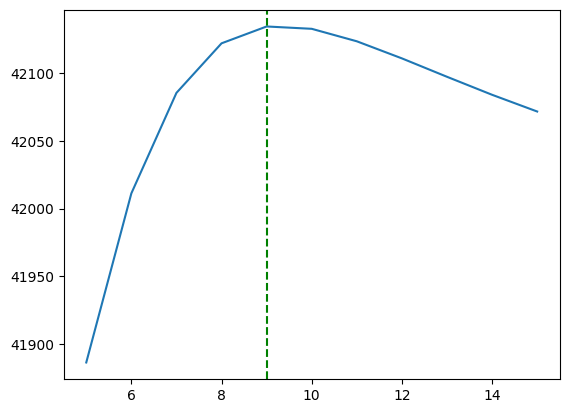

In [15]:
plt.plot(np.arange(5,16),profit)
plt.axvline(x=np.arange(5,16)[np.argmax(profit)], color='green', linestyle='--', label='Vertical Line at Highest Point')


# Third Part

In [16]:
ndays = 365
T = ndays

nseat_coa = 100
nseat_1st = 20
nseat_over = 20

showup_coa = 0.95
showup_1st = 0.97

bump_1st = 50
bump_out = 425

price_coa = [300,350]
price_1st = [425,500]

# 0 - LL
# 1 - HL
# 2 - LH
# 3 - HH
# 4 - L0
# 5 - H0
# 6 - 0L
# 7 - 0H
# 8 - 00

dema_coa = [0.65,0.3]
dema_1st = [0.08,0.04]

r_year = 0.17
r = 1/(1+r_year/365)

extra_d = 0.03



In [17]:
#state variables
s_coa_values = np.arange(nseat_coa+nseat_over+1) #number of seats sold coa
s_1st_values = np.arange(nseat_1st+1) #number of seats sold 1st
t_values = np.arange(ndays+1)

In [18]:
#value function
V = np.zeros((nseat_1st+1,nseat_coa+nseat_over+1,ndays+1))
U = np.empty((nseat_1st+1,nseat_coa+nseat_over+1,ndays+1))

In [19]:
#terminal
for s_1st in s_1st_values:
    for s_coa in s_coa_values:
        exp_cost = 0
        for n_1st in range(s_1st+1):
            for n_coa in range(s_coa+1):
                prob_show_1st = binom.pmf(n_1st, s_1st, showup_1st)
                prob_show_coa = binom.pmf(n_coa, s_coa, showup_coa)
                n_ava_1st = nseat_1st-n_1st
                if n_coa>nseat_coa:
                    if (n_coa-nseat_coa)<=n_ava_1st:
                        cost = (n_coa-nseat_coa)*bump_1st
                    else:
                        cost = n_ava_1st*bump_1st+(n_coa-nseat_coa-n_ava_1st)*bump_out
                else:
                    cost=0

                exp_cost += cost*prob_show_1st*prob_show_coa                
        V[s_1st,s_coa,T] = -exp_cost

In [20]:
# Belman
for t in reversed(range(ndays)):
    for s_1st in s_1st_values:
        if s_1st==nseat_1st:
            for s_coa in (s_coa_values):
                if s_coa==(nseat_coa+nseat_over):
                    V[s_1st,s_coa,t] = 0 + r*V[s_1st,s_coa,t+1]
                    U[s_1st,s_coa,t] = 8
                else:
                    v_coa_1st = [price_coa[0]*(dema_coa[0]+extra_d)+r*(V[s_1st,s_coa+1,t+1]*(dema_coa[0]+extra_d)+
                                                                       V[s_1st,s_coa,t+1]*(1-dema_coa[0]-extra_d)),
                                 
                                 price_coa[1]*(dema_coa[1]+extra_d)+r*(V[s_1st,s_coa+1,t+1]*(dema_coa[1]+extra_d)+
                                                                       V[s_1st,s_coa,t+1]*(1-dema_coa[1]-extra_d)),
                                
                                 0 + r*V[s_1st,s_coa,t+1]
                                ] 
                    
                    V[s_1st,s_coa,t] = np.max(v_coa_1st)
                    U[s_1st,s_coa,t] = 6 + np.argmax(v_coa_1st)                                      
        else:
            for s_coa in (s_coa_values):
                if s_coa==(nseat_coa+nseat_over):
                    v_coa_1st = [price_1st[0]*dema_1st[0]+r*(V[s_1st+1,s_coa,t+1]*dema_1st[0]+
                                                             V[s_1st,s_coa,t+1]*(1-dema_1st[0])),
                                 price_1st[1]*dema_1st[1]+r*(V[s_1st+1,s_coa,t+1]*dema_1st[1]+
                                                             V[s_1st,s_coa,t+1]*(1-dema_1st[1]))
                                ]

                    V[s_1st,s_coa,t] = np.max(v_coa_1st)
                    U[s_1st,s_coa,t] = np.argmax(v_coa_1st)+4   
                else:  
                    
                    v_coa_1st = [(price_1st[0]+price_coa[0])*dema_1st[0]*dema_coa[0]+
                                 (price_1st[0])*dema_1st[0]*(1-dema_coa[0])+
                                 (price_coa[0])*(1-dema_1st[0])*dema_coa[0]+r*(V[s_1st+1,s_coa+1,t+1]*dema_1st[0]*dema_coa[0]+
                                                                               V[s_1st+1,s_coa  ,t+1]*dema_1st[0]*(1-dema_coa[0])+
                                                                               V[s_1st,s_coa+1,t+1]*(1-dema_1st[0])*dema_coa[0] +
                                                                               V[s_1st,s_coa,t+1]*(1-dema_1st[0])*(1-dema_coa[0])),
                                 (price_1st[1]+price_coa[0])*dema_1st[1]*dema_coa[0]+
                                 (price_1st[1])*dema_1st[1]*(1-dema_coa[0])+
                                 (price_coa[0])*(1-dema_1st[1])*dema_coa[0]+r*(V[s_1st+1,s_coa+1,t+1]*dema_1st[1]*dema_coa[0]+
                                                                               V[s_1st+1,s_coa  ,t+1]*dema_1st[1]*(1-dema_coa[0])+
                                                                               V[s_1st,s_coa+1,t+1]*(1-dema_1st[1])*dema_coa[0] +
                                                                               V[s_1st,s_coa,t+1]*(1-dema_1st[1])*(1-dema_coa[0])),
                                 (price_1st[0]+price_coa[1])*dema_1st[0]*dema_coa[1]+
                                 (price_1st[0])*dema_1st[0]*(1-dema_coa[1])+
                                 (price_coa[1])*(1-dema_1st[0])*dema_coa[1]+r*(V[s_1st+1,s_coa+1,t+1]*dema_1st[0]*dema_coa[1]+
                                                                               V[s_1st+1,s_coa  ,t+1]*dema_1st[0]*(1-dema_coa[1])+
                                                                               V[s_1st,s_coa+1,t+1]*(1-dema_1st[0])*dema_coa[1] +
                                                                               V[s_1st,s_coa,t+1]*(1-dema_1st[0])*(1-dema_coa[1])),
                                 (price_1st[1]+price_coa[1])*dema_1st[1]*dema_coa[1]+
                                 (price_1st[1])*dema_1st[1]*(1-dema_coa[1])+
                                 (price_coa[1])*(1-dema_1st[1])*dema_coa[1]+r*(V[s_1st+1,s_coa+1,t+1]*dema_1st[1]*dema_coa[1]+
                                                                               V[s_1st+1,s_coa  ,t+1]*dema_1st[1]*(1-dema_coa[1])+
                                                                               V[s_1st,s_coa+1,t+1]*(1-dema_1st[1])*dema_coa[1] +
                                                                               V[s_1st,s_coa,t+1]*(1-dema_1st[1])*(1-dema_coa[1])),

                                 price_1st[0]*dema_1st[0]+r*(V[s_1st+1,s_coa,t+1]*dema_1st[0]+
                                                             V[s_1st,s_coa,t+1]*(1-dema_1st[0])),
                                 
                                 price_1st[1]*dema_1st[1]+r*(V[s_1st+1,s_coa,t+1]*dema_1st[1]+
                                                             V[s_1st,s_coa,t+1]*(1-dema_1st[1]))
                                ]                    

                    V[s_1st,s_coa,t] = np.max(v_coa_1st)
                    U[s_1st,s_coa,t] = np.argmax(v_coa_1st)  



In [21]:
with open('Question3_V_2ndPolicy.npy', 'wb') as f:
    np.save(f, V)

with open('Question3_U_2ndPolicy.npy', 'wb') as f:
    np.save(f, U)
    

In [22]:
V[0,0,0]

42139.89276231962

In [23]:
V_1stpol, U_1stpol = run_get_profit(20)
V_1stpol[0,0,0]

42028.73703811088

In [24]:
V_1stpol_9, U_1stpol_9 = run_get_profit(9)
V_1stpol_9[0,0,0]

42134.62483034151

In [25]:
with open('Question3_V_1stPolicy.npy', 'wb') as f:
    np.save(f, V_1stpol)

with open('Question3_U_1stPolicy.npy', 'wb') as f:
    np.save(f, U_1stpol)

In [26]:
with open('Question3_V_1stPolicy9.npy', 'wb') as f:
    np.save(f, V_1stpol_9)

with open('Question3_U_1stPolicy9.npy', 'wb') as f:
    np.save(f, U_1stpol_9)

# Fourth part

In [27]:
import random

In [28]:
ndays = 365
T = ndays

nseat_coa = 100
nseat_1st = 20

showup_coa = 0.95
showup_1st = 0.97

bump_1st = 50
bump_out = 425

price_coa = [300,350,0]
price_1st = [425,500,0]

dema_coa = [0.65,0.3,0]
dema_1st = [0.08,0.04,0]

# 0 - LL
# 1 - HL
# 2 - LH
# 3 - HH
# 4 - L0
# 5 - H0
# 6 - 0L
# 7 - 0H
# 8 - 00

price_probdem_1st = {0:0,1:1,2:0,3:1,4:0,5:1,6:2,7:2,8:2}
price_probdem_coa = {0:0,1:0,2:1,3:1,4:2,5:2,6:0,7:1,8:2}

r_year = 0.17
r = 1/(1+r_year/365)

extra_d = 0.03

In [29]:
with open('Question3_V_2ndPolicy.npy', 'rb') as f:
    V_2ndPolicy = np.load(f)

with open('Question3_U_2ndPolicy.npy', 'rb') as f:
    U_2ndPolicy = np.load(f)

with open('Question3_V_1stPolicy.npy', 'rb') as f:
    V_1stPolicy = np.load(f)

with open('Question3_U_1stPolicy.npy', 'rb') as f:
    U_1stPolicy = np.load(f)

with open('Question3_V_1stPolicy9.npy', 'rb') as f:
    V_1stPolicy9 = np.load(f)

with open('Question3_U_1stPolicy9.npy', 'rb') as f:
    U_1stPolicy9 = np.load(f)
    

In [30]:
U_1stPolicy[0,0,0]

2.0

In [31]:
U_2ndPolicy[0,0,0]

2.0

In [32]:
U_1stPolicy9[0,0,0]

2.0

In [33]:
def generate_model_overbook(U):
    s_coa = 0
    s_1st = 0
    total_rev = 0
    rev_ts = []
    prices_ts = []
    kick_off = 0
    overbook_cost = 0
    overbook_level = 0
    
    for t in range(ndays):
        decision = U[s_1st,s_coa,t]
        index_1st = price_probdem_1st[decision]
        index_coa = price_probdem_coa[decision]
        price_coa_t = price_coa[index_coa]
        price_1st_t = price_1st[index_1st]
        prob_coa_t = dema_coa[index_coa]
        prob_1st_t = dema_1st[index_1st]
        
        if (s_1st==nseat_1st)|(price_1st_t==0):
            if (s_coa==(nseat_coa+nseat_over)) | (price_coa_t==0):
                prices_ts += [[0,0]]
                rev_ts += [0]               
            else:
                n_ticket_coa = (np.random.random(1)<(prob_coa_t+extra_d))[0]*1
                s_coa+=n_ticket_coa
                prices_ts += [[0,price_coa_t]]
                rev_t = (r**(t))*(n_ticket_coa*price_coa_t)
                rev_ts += [rev_t]
                total_rev+=rev_t
        else:
            if (s_coa==(nseat_coa+nseat_over))|(price_coa_t==0):
                n_ticket_1st = (np.random.random(1)<prob_1st_t)[0]*1
                s_1st += n_ticket_1st
                prices_ts += [[price_1st_t,0]]
                rev_t = (r**(t))*(n_ticket_1st*price_1st_t)
                rev_ts += [rev_t]
                total_rev += rev_t                
            else:
                n_ticket_coa = (np.random.random(1)<prob_coa_t)[0]*1
                n_ticket_1st = (np.random.random(1)<prob_1st_t)[0]*1
                s_coa+=n_ticket_coa
                s_1st += n_ticket_1st
                prices_ts += [[price_1st_t,price_coa_t]]
                rev_t = (r**(t))*(n_ticket_coa*price_coa_t + n_ticket_1st*price_1st_t)
                rev_ts += [rev_t]
                total_rev+=rev_t  

    n_ava_1st = nseat_1st-s_1st
    if s_coa>nseat_coa:
        overbook_level = s_coa-nseat_coa
        if (s_coa-nseat_coa)<=n_ava_1st:
            cost = (s_coa-nseat_coa)*bump_1st*(r**(T))
        else:
            cost = (n_ava_1st*bump_1st+(s_coa-nseat_coa-n_ava_1st)*bump_out)*(r**(T))
            kick_off=s_coa-nseat_coa-n_ava_1st

    else:
        cost=0
        
    overbook_cost = cost
    
    rev_ts += [-cost]
    prices_ts += [[0,0]]
    total_rev -= cost    
    
    return rev_ts, prices_ts, overbook_level,kick_off,overbook_cost,total_rev

## 1st policy overbook 20

In [34]:
#U_2ndPolicy
#U_1stPolicy
#U_1stPolicy9
nseat_over = 20
n_sim = 10000
total_overbook_level_1stP20= []
total_kickoff_1stP20 = []
total_overbook_cost_1stP20 = []
total_total_rev_1stP20 = []
for i in range(n_sim):
    rev_ts, prices_ts, overbook_level,kick_off,overbook_cost,total_rev = generate_model_overbook(U_1stPolicy)
    total_kickoff_1stP20 += [kick_off]
    total_overbook_cost_1stP20 += [overbook_cost]
    total_total_rev_1stP20 += [total_rev]
    total_overbook_level_1stP20 += [overbook_level]


In [35]:
summary = pd.DataFrame()

summary['vars'] = ['sum_times_kickoff','sum_times_overbook','avg_overbook_level_1stP20','avg_kickoff_1stP20','avg_overbook_cost_1stP20','avg_total_rev_1stP20']

summary['avg'] = [  np.sum(np.array(total_overbook_level_1stP20)>0)
                    ,np.sum(np.array(total_kickoff_1stP20)>0)
                    ,np.mean(total_overbook_level_1stP20)
                    ,np.mean(total_kickoff_1stP20)
                    ,np.mean(total_overbook_cost_1stP20)
                    ,np.mean(total_total_rev_1stP20)]

summary['std'] = [  np.sum(np.array(total_overbook_level_1stP20)>0)*(1-np.sum(np.array(total_overbook_level_1stP20)>0))
                    ,np.sum(np.array(total_kickoff_1stP20)>0)*(1-np.sum(np.array(total_kickoff_1stP20)>0))
                    ,np.std(total_overbook_level_1stP20)
                    ,np.std(total_kickoff_1stP20)
                    ,np.std(total_overbook_cost_1stP20)
                    ,np.std(total_total_rev_1stP20)]

summary


,vars,avg,std
0,sum_times_kickoff,10000.000000,-9.999000e+07
1,sum_times_overbook,10000.000000,-9.999000e+07
2,avg_overbook_level_1stP20,11.669700,5.013362e+00
3,avg_kickoff_1stP20,10.845700,4.663828e+00
4,avg_overbook_cost_1stP20,3923.721864,1.680565e+03
5,avg_total_rev_1stP20,39950.385333,5.272270e+02


## 1st policy overbook 9

In [36]:
#U_2ndPolicy
#U_1stPolicy
#U_1stPolicy9
nseat_over = 9
n_sim = 10000
total_overbook_level_1stP9= []
total_kickoff_1stP9 = []
total_overbook_cost_1stP9 = []
total_total_rev_1stP9 = []
for i in range(n_sim):
    rev_ts, prices_ts, overbook_level,kick_off,overbook_cost,total_rev = generate_model_overbook(U_1stPolicy9)
    total_kickoff_1stP9 += [kick_off]
    total_overbook_cost_1stP9 += [overbook_cost]
    total_total_rev_1stP9 += [total_rev]
    total_overbook_level_1stP9 += [overbook_level]

In [37]:
summary = pd.DataFrame()

summary['vars'] = ['sum_times_kickoff','sum_times_overbook','avg_overbook_level_1stP9','avg_kickoff_1stP9','avg_overbook_cost_1stP9','avg_total_rev_1stP9']

summary['avg'] = [  np.sum(np.array(total_overbook_level_1stP9)>0)
                    ,np.sum(np.array(total_kickoff_1stP9)>0)
                    ,np.mean(total_overbook_level_1stP9)
                    ,np.mean(total_kickoff_1stP9)
                    ,np.mean(total_overbook_cost_1stP9)
                    ,np.mean(total_total_rev_1stP9)]

summary['std'] = [  np.sum(np.array(total_overbook_level_1stP9)>0)*(1-np.sum(np.array(total_overbook_level_1stP9)>0))
                    ,np.sum(np.array(total_kickoff_1stP9)>0)*(1-np.sum(np.array(total_kickoff_1stP9)>0))
                    ,np.std(total_overbook_level_1stP9)
                    ,np.std(total_kickoff_1stP9)
                    ,np.std(total_overbook_cost_1stP9)
                    ,np.std(total_total_rev_1stP9)]

summary


,vars,avg,std
0,sum_times_kickoff,10000.000000,-9.999000e+07
1,sum_times_overbook,9999.000000,-9.997000e+07
2,avg_overbook_level_1stP9,8.185300,1.204643e+00
3,avg_kickoff_1stP9,7.799700,1.320371e+00
4,avg_overbook_cost_1stP9,2813.018485,4.593848e+02
5,avg_total_rev_1stP9,40152.223042,5.859683e+02


## 2nd policy overbook 20

In [38]:
#U_2ndPolicy
#U_1stPolicy
#U_1stPolicy9
nseat_over = 20
n_sim = 10000
total_overbook_level_2nd= []
total_kickoff_2nd = []
total_overbook_cost_2nd = []
total_total_rev_2nd = []
for i in range(n_sim):
    rev_ts, prices_ts, overbook_level,kick_off,overbook_cost,total_rev = generate_model_overbook(U_2ndPolicy)
    total_kickoff_2nd += [kick_off]
    total_overbook_cost_2nd += [overbook_cost]
    total_total_rev_2nd += [total_rev]
    total_overbook_level_2nd += [overbook_level]

In [39]:
summary = pd.DataFrame()

summary['vars'] = ['sum_times_kickoff','sum_times_overbook','avg_overbook_level_2nd','avg_kickoff_2nd','avg_overbook_cost_2nd','avg_total_rev_2nd']

summary['avg'] = [  np.sum(np.array(total_overbook_level_2nd)>0)
                    ,np.sum(np.array(total_kickoff_2nd)>0)
                    ,np.mean(total_overbook_level_2nd)
                    ,np.mean(total_kickoff_2nd)
                    ,np.mean(total_overbook_cost_2nd)
                    ,np.mean(total_total_rev_2nd)]

summary['std'] = [  np.sum(np.array(total_overbook_level_2nd)>0)*(1-np.sum(np.array(total_overbook_level_2nd)>0))
                    ,np.sum(np.array(total_kickoff_2nd)>0)*(1-np.sum(np.array(total_kickoff_2nd)>0))
                    ,np.std(total_overbook_level_2nd)
                    ,np.std(total_kickoff_2nd)
                    ,np.std(total_overbook_cost_2nd)
                    ,np.std(total_total_rev_2nd)]

summary


,vars,avg,std
0,sum_times_kickoff,10000.000000,-9.999000e+07
1,sum_times_overbook,10000.000000,-9.999000e+07
2,avg_overbook_level_2nd,8.386100,1.466297e+00
3,avg_kickoff_2nd,7.931600,1.306951e+00
4,avg_overbook_cost_2nd,2863.220638,4.648425e+02
5,avg_total_rev_2nd,40143.843730,5.900637e+02


## Histogram comparisons

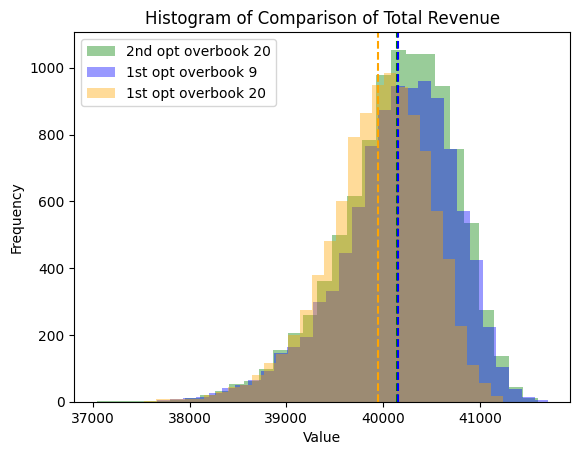

In [40]:
plt.hist(total_total_rev_2nd, bins=30, alpha=0.4, label='2nd opt overbook 20', color='green')
plt.hist(total_total_rev_1stP9, bins=30, alpha=0.4, label='1st opt overbook 9', color='blue')
plt.hist(total_total_rev_1stP20, bins=30, alpha=0.4, label='1st opt overbook 20',color='orange')

plt.axvline(x=np.mean(total_total_rev_2nd), color='green', linestyle='--')
plt.axvline(x=np.mean(total_total_rev_1stP9), color='blue', linestyle='--')
plt.axvline(x=np.mean(total_total_rev_1stP20), color='orange', linestyle='--')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Comparison of Total Revenue')
plt.legend()

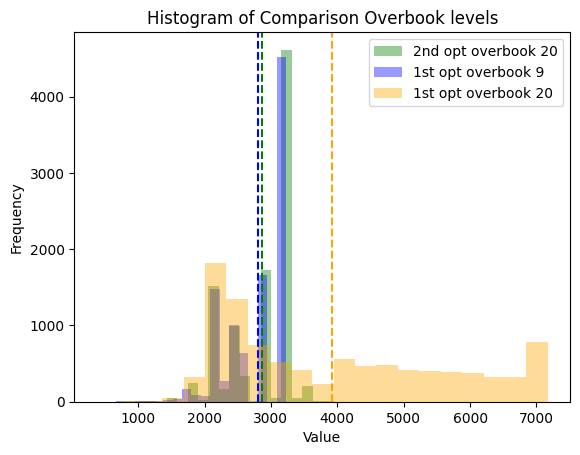

In [41]:
plt.hist(total_overbook_cost_2nd, bins=20, alpha=0.4, label='2nd opt overbook 20', color='green')
plt.hist(total_overbook_cost_1stP9, bins=20, alpha=0.4, label='1st opt overbook 9', color='blue')
plt.hist(total_overbook_cost_1stP20, bins=20, alpha=0.4, label='1st opt overbook 20',color='orange')

plt.axvline(x=np.mean(total_overbook_cost_2nd), color='green', linestyle='--')
plt.axvline(x=np.mean(total_overbook_cost_1stP9), color='blue', linestyle='--')
plt.axvline(x=np.mean(total_overbook_cost_1stP20), color='orange', linestyle='--')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Comparison Overbook levels')
plt.legend()

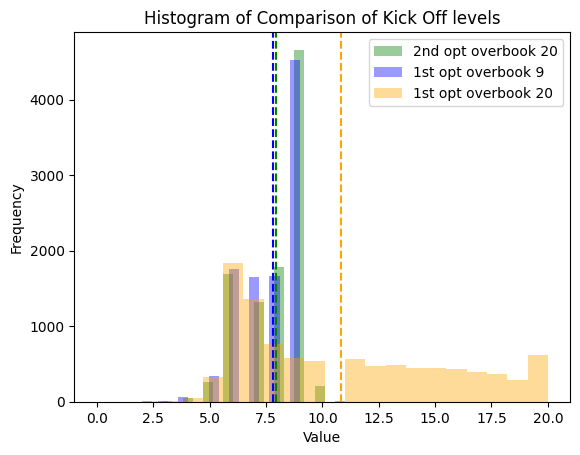

In [42]:
plt.hist(total_kickoff_2nd, bins=20, alpha=0.4, label='2nd opt overbook 20', color='green')
plt.hist(total_kickoff_1stP9, bins=20, alpha=0.4, label='1st opt overbook 9', color='blue')
plt.hist(total_kickoff_1stP20, bins=20, alpha=0.4, label='1st opt overbook 20',color='orange')

plt.axvline(x=np.mean(total_kickoff_2nd), color='green', linestyle='--')
plt.axvline(x=np.mean(total_kickoff_1stP9), color='blue', linestyle='--')
plt.axvline(x=np.mean(total_kickoff_1stP20), color='orange', linestyle='--')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Comparison of Kick Off levels')
plt.legend()